In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join(".", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# 연구용 딥 에이전트

## 개요

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이제 지금까지 배운 내용을 종합해 보겠습니다:

* 작업 추적을 위해 **TODO**를 사용할 것입니다.
* 원시 도구 호출 결과를 저장하기 위해 **파일**을 사용할 것입니다.
* 컨텍스트 격리를 위해 **연구 작업을 하위 에이전트에 위임**할 것입니다. 

## 검색 도구

원시 콘텐츠를 파일로 오프로드하고 에이전트에는 요약만 반환하는 검색 도구를 구축합니다. 이는 장시간 실행되는 에이전트 트래지토리에서 흔히 사용되는 패턴으로, [Manus 사례](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)에서도 확인한 바 있습니다!

### 핵심 구성 요소

1. **검색 실행 (`run_tavily_search`)**: 결과 수 및 주제 필터링을 위한 구성 가능한 매개변수와 함께 Tavily API를 사용하여 실제 웹 검색을 수행합니다.

2. **콘텐츠 요약 (`summarize_webpage_content`)**: 경량 모델(GPT-4o-mini)을 활용해 웹페이지 콘텐츠의 구조화된 요약을 생성하며, 설명적 파일명과 핵심 학습 요약문을 동시에 산출합니다.

3. **결과 처리 (`process_search_results`)**: HTTP를 통해 전체 웹페이지 콘텐츠를 가져오고, `markdownify`를 사용하여 HTML을 마크다운으로 변환하며, 각 결과에 대한 요약문을 생성합니다.

4. **컨텍스트 오프로딩 (`tavily_search` 도구)**: 주요 도구로 다음을 수행합니다:
   - 검색 실행 및 결과 처리
   - 전체 콘텐츠를 에이전트 상태 파일로 저장(컨텍스트 오프로딩)
   - 에이전트에 최소한의 요약만 반환(컨텍스트 스팸 방지)
   - LangGraph `Command`를 사용하여 파일과 메시지 모두 업데이트

5. **전략적 사고(`think_tool`)**: 에이전트가 연구 워크플로우에서 발견 사항을 분석하고, 부족한 부분을 평가하며, 다음 단계를 계획할 수 있도록 구조화된 성찰 메커니즘을 제공합니다.

이 아키텍처는 상세한 검색 결과를 파일에 저장함으로써 토큰 효율성 문제를 해결하는 동시에 에이전트의 작업 컨텍스트를 최소화하고 집중시킵니다.

In [2]:
%%writefile ./src/deep_agents_from_scratch/research_tools.py
"""연구 도구.

이 모듈은 연구 에이전트를 위한 검색 및 콘텐츠 처리 유틸리티를 제공하며,
웹 검색 기능과 콘텐츠 요약 도구를 포함합니다.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """연구 진행 상황과 의사결정에 대한 전략적 성찰 도구.

    각 검색 후 이 도구를 사용하여 결과를 분석하고 다음 단계를 체계적으로 계획하세요.
    이는 질적 의사결정을 위한 연구 워크플로우 내 의도적인 일시 정지를 만듭니다.

    사용 시점:
    - 검색 결과 수신 후: 어떤 핵심 정보를 찾았는가?
    - 다음 단계 결정 전: 포괄적으로 답변하기에 충분한가?
    - 연구 공백 평가 시: 아직 부족한 구체적인 정보는 무엇인가?
    - 연구 마무리 전: 지금 완전한 답변을 제공할 수 있는가?
    - 질문의 복잡성: 검색 횟수 한도에 도달했는가?

    반성 시 다루어야 할 사항:
    1. 현재 발견 사항 분석 - 어떤 구체적인 정보를 수집했는가?
    2. 공백 평가 - 여전히 부족한 핵심 정보는 무엇인가?
    3. 질적 평가 - 양질의 답변을 위한 충분한 증거나 사례가 있는가?
    4. 전략적 결정 - 검색을 계속할 것인가, 답변을 제공할 것인가?

    Args:
        reflection: 연구 진행 상황, 발견 사항, 공백, 다음 단계에 대한 상세한 반성

    Returns:
        의사결정을 위한 반성 기록 확인
    """
    return f"Reflection recorded: {reflection}"

Overwriting ./src/deep_agents_from_scratch/research_tools.py


## 딥 에이전트

이제 지금까지 배운 내용을 모두 적용해 보겠습니다:

* 연구원에게 `think_tool`과 위의 `search_tool`을 제공합니다.
* 부모 에이전트 파일에는 도구, `think_tool`, 그리고 `task` 도구를 제공합니다. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from notebooks.utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "하위 에이전트 연구원에게 연구를 위임하십시오. 이 연구원에게는 한 번에 하나의 주제만 부여하십시오.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %#d, %Y"),
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  당신은 사용자의 입력 주제에 대한 연구를 수행하는 연구 조수입니다. 참고로 오늘 날짜는 {date}입니다.             │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  당신의 임무는 도구를 사용하여 사용자의 입력 주제에 대한 정보를 수집하는 것입니다.                              │
│  제공된 도구를 사용하여 연구 질문에 답하는 데 도움이 되는 자료를 찾을 수 있습니다. 이러한 도구는 직렬 또는      │
│  병렬로 호출할 수 있으며, 연구는 도구 호출 루프에서 수행됩니다.                                                 │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  두 가지 주요 도구를 사용할 수 있습니다:                                                                        │
│  1. **tavily_search**: 웹 검색을 수행하여 정보 수집                                                             │
│  2. **think_tool**: 연구 중 성찰 및 전략 계획 수립                                                              │
│                                                                                                                 │
│  **중요: 각 검색 후 think_tool을 사용하여 결과를 성찰하고 다음 단계를 계획하세요**                              │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  시간이 제한된 인간 연구원처럼 생각하세요. 다음 단계를 따르세요:                                                │
│                                                                                                                 │
│  1. **질문을 주의 깊게 읽기** - 사용자가 어떤 구체적인 정보를 필요로 하는가?                                    │
│  2. **더 넓은 범위의 검색으로 시작하기** - 먼저 광범위하고 포괄적인 검색어 사용                                 │
│  3. **각 검색 후 잠시 멈추고 평가하기** - 답변하기에 충분한 정보가 있는가? 아직 무엇이 부족한가?                │
│  4. **정보를 수집하면서 더 좁은 범위의 검색 실행하기** - 부족한 부분 채우기                                     │
│  5. **자신 있게 답변할 수 있을 때 중단하기** - 완벽을 위해 계속 검색하지 말기                                   │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **도구 호출 예산** (과도한 검색 방지):                                                                         │
│  - **단순한 검색**: 최대 1-2회 검색 도구 호출 사용                                                              │
│  - **일반적인 검색**: 최대 2-3회 검색 도구 호출 사용                                                            │
│  - **매우 복잡한 검색**: 최대 5회 검색 도구 호출 사용                                                           │
│  - **항상 중단**: 5회 검색 도구 호출 후에도 적절한 자료를 찾지 못하면 중단                                      │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  **다음과 같은 경우 즉시 중단**:                                                                                │
│  - 사용자의 질문에 포괄적으로 답변할 수 있을 때                                                                 │
│  - 질문에 대한 관련 예시/자료가 3개 이상 있을 때                                                                │
│  -

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  사용자의 요청에 따라:                                                                                          │
│  1. 도구 설명에 따라 사용자 요청 시작 시 write_todos 도구를 사용하여 TODO를 생성합니다.                         │
│  2. TODO를 완료한 후, read_todos를 사용하여 계획을 상기하기 위해 TODO 목록을 읽습니다.                          │
│  3. 수행한 작업과 TODO를 성찰합니다.                                                                            │
│  4. 작업을 완료됨으로 표시하고 다음 TODO로 진행합니다.                                                          │
│  5. 모든 TODO를 완료할 때까지 이 과정을 계속합니다.                                                             │
│                                                                                                                 │
│  중요: 모든 사용자 요청에 대해 항상 TODO 연구 계획을 수립하고 위 지침에 따라 연구를 수행하세요.                 │
│  중요: 추적해야 할 TODO의 수를 최소화하기 위해 연구 작업을 *단일 TODO*로 묶는 것을 목표로 하세요.               │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  컨텍스트를 유지하고 저장하는 데 도움이 되는 가상 파일 시스템에 접근할 수 있습니다.                             │
│                                                                                                                 │
│  ## 워크플로우 프로세스                                                                                         │
│  1. **상황 파악**: 작업을 시작하기 전에 ls()를 사용하여 기존 파일을 확인합니다.                                 │
│  2. **저장**: 나중에 참조할 수 있도록 사용자의 요청을 저장하기 위해 write_file()을 사용합니다.                  │
│  3. **연구**: 연구를 진행합니다. 검색 도구가 파일을 작성할 것입니다.                                            │
│  4. **읽기**: 수집된 자료에 만족하면 파일을 읽고 사용자의 질문에 직접 답변하는 데 사용합니다.                   │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  하위 에이전트에게 작업을 위임할 수 있습니다.                                                                   │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  당신의 역할은 특정 연구 작업을 하위 에이전트에게 위임하여 연구를 조율하는 것입니다.                            │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: 전문 하위 에이전트에게 연구 작업 위임                                 │
│     - description: 명확하고 구체적인 연구 질문 또는 작업                                                        │
│     - subagent_type: 사용할 에

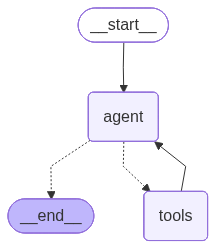

In [6]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from notebooks.utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기",                                 │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_FNpbbphA5Yk1lkuPlXZIqqGJ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': '모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기', 'status':      │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기",                                 │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_l3ihkgcP7YbfEN9NYS1oVqG9                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 AI 시스템의 데이터 검색과 통합을 표준화하는 오픈 소스 프레임워크입니다. 이        │
│ 프로토콜은 AI가 구조화된 데이터를 동적으로 활용할 수 있도록 지원하며, 서비스 간 연결을 자동으로 관리하여 AI     │
│ 에이전트의 맥락 적응성을 개선합니다. MCP는 API와 데이터베이스 통합의 복잡성을 줄이는 데 기여하며, 다양한 사용   │
│ 사례로는 DevOps, 규정 준수, 코딩 컴패니언 기능 등이 있습니다.                                                   │
│                                                                                                                 │
│ MCP의 핵심 요소는 클라이언트와 서버 간의 명확한 프로토콜 규칙으로, 개발자는 이를 통해 실시간으로 정보를         │
│ 요청하고 제공할 수 있습니다. 이는 강력한 AI 어시스턴트를 구축하는 데 필수적이며, 특히 의료 영상 분석과 같은     │
│ 실제 애플리케이션에서 큰 잠재력을 보여줍니다. 그러나 초기 설정의 복잡성과 성능 오버헤드 같은 단점도 존재합니다. │
│                                                                                                                 │
│ 이 정보는 MCP의 기본 개념과 기술적 세부사항, 실제 사례를 포함하고 있어 포괄적인 이해를 돕습니다. 추가적인       │
│ 질문이 있으시면 언제든지 말씀해 주세요!                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "findings_model_context_protocol.md",                                                            │
│   "content": "모델 컨텍스트 프로토콜(MCP)은 AI 시스템의 데이터 검색과 통합을 표준화하는 오픈 소스               │
│ 프레임워크입니다. 이 프로토콜은 AI가 구조화된 데이터를 동적으로 활용할 수 있도록 지원하며, 서비스 간 연결을     │
│ 자동으로 관리하여 AI 에이전트의 맥락 적응성을 개선합니다. MCP는 API와 데이터베이스 통합의 복잡성을 줄이는 데    │
│ 기여하며, 다양한 사용 사례로는 DevOps, 규정 준수, 코딩 컴패니언 기능 등이 있습니다.\n\nMCP의 핵심 요소는        │
│ 클라이언트와 서버 간의 명확한 프로토콜 규칙으로, 개발자는 이를 통해 실시간으로 정보를 요청하고 제공할 수        │
│ 있습니다. 이는 강력한 AI 어시스턴트를 구축하는 데 필수적이며, 특히 의료 영상 분석과 같은 실제 애플리케이션에서  │
│ 큰 잠재력을 보여줍니다. 그러나 초기 설정의 복잡성과 성능 오버헤드 같은 단점도 존재합니다.\n\n이 정보는 MCP의    │
│ 기본 개념과 기술적 세부사항, 실제 사례를 포함하고 있어 포괄적인 이해를 돕습니다."                               │
│ }                                                                                                               │
│    ID: call_HiMAUXKAGJ25qyMOHtnSQh3G                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file findings_model_context_protocol.md                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: call_OGnNe6vBmdizzcLNQlSb0Pxq                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기 (pending)                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기",                                 │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_3fG3iheLJW6iDSmjvs2xbaiv                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': '모델 컨텍스트 프로토콜(MCP)에 대한 개요를 조사하고 요약하기', 'status':      │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 성공적으로 조사하고 요약했습니다. 이 정보는 MCP의 기본 개념, 기술적   │
│ 세부사항, 실제 사례를 포함하고 있습니다. 추가적인 질문이 있으시면 언제든지 말씀해 주세요!                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Deep Agent 패키지 사용하기

이제 기본 패턴을 이해하셨습니다! 

간단한 추상화로서 [`deepagents` 패키지](
https://github.com/hwchase17/deepagents)를 사용할 수 있습니다:

* 파일 시스템 도구를 포함합니다
* 할 일 관리 도구를 포함합니다
* 작업 관리 도구를 포함합니다

서브 에이전트와 해당 서브 에이전트가 사용하기 원하는 도구만 제공하면 됩니다.

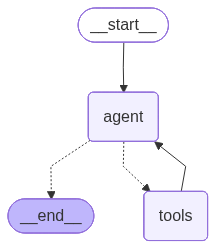

In [8]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
from notebooks.utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Provide an overview of the Model Context Protocol (MCP), including its purpose, key features, │
│ and applications.",                                                                                             │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_GPPZvekiXmx1pp8S5LY2q1mH                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ### Overview of the Model Context Protocol (MCP)                                                                │
│                                                                                                                 │
│ **Purpose:**                                                                                                    │
│ The Model Context Protocol (MCP) is an open-source standard designed to create a unified framework for          │
│ connecting AI models with various data sources, tools, and external applications. Its primary goal is to        │
│ facilitate seamless interactions between AI systems and external services, enhancing the capabilities of AI     │
│ models in real-world applications.                                                                              │
│                                                                                                                 │
│ **Key Features:**                                                                                               │
│ 1. **Unified Language:** MCP establishes a standardized interface that replaces the need for custom code,       │
│ allowing for easier integration of AI applications with APIs.                                                   │
│ 2. **Real-time, Bidirectional Communication:** Unlike traditional APIs that typically operate on a              │
│ request-response basis, MCP supports real-time interactions, enabling dynamic exchanges of information.         │
│ 3. **Plug-and-Play Integration:** MCP allows for rapid integration of new tools and data sources with minimal   │
│ effort, enhancing the flexibility of AI systems.                                                                │
│ 4. **OAuth-based Authentication:** This feature improves security for multi-user applications and supports      │
│ dynamic client registration, ensuring secure interactions.                                                      │
│ 5. **Enhanced Autonomy for AI Agents:** MCP empowers AI agents to make decisions based on real-time context,    │
│ improving their effectiveness in various tasks.                                                                 │
│                                                                                                                 │
│ **Applications:**                                                                                               │
│ MCP has been applied in several practical scenarios, including:                                                 │
│ 1. **IT Service Management:** Streamlining processes and improving efficiency in managing IT services.          │
│ 2. **Recruitment Automation:** Enhancing the recruitment process by automating candidate sourcing and           │
│ evaluation.                                                                                                     │
│ 3. **Vendor Negotiation Support:** Assisting in negotiations with suppliers by providing relevant data and      │
│ insights.                                                                                                       │
│ 4. **Expense Review Automation:** Automating the review of expenses to ensure compliance and accuracy.          │
│                                                                                                                 │
│ These applications demonstrate MCP's versatility and effectiveness in improving business processes across       │
│ different sectors.                                                                                              │
│                                                                                                                 │
│ ### Conclusion                                                                                                  │
│ The Model Context Protocol (MCP) serves as a crucial to

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Provide an overview of the Model Context Protocol (MCP), including its purpose, key features, │
│ and applications.",                                                                                             │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_ZDbHBtoswYwI2umIIuhDLZgC                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Provide an overview of the Model Context Protocol (MCP), including its       │
│ purpose, key features, and applications.', 'status': 'completed'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/path/to/todos"                                                                                 │
│ }                                                                                                               │
│    ID: call_eoTVgh9XCbuNGYCK4Lu1dwPu                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: File '/path/to/todos' not found                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I provided a comprehensive overview of the Model Context Protocol (MCP), detailing its         │
│ purpose, key features, and applications. The information covers the standard's role in enhancing AI model       │
│ integration with external systems, emphasizing its benefits in real-time communication and security. Since the  │
│ task is complete, I will mark it as done."                                                                      │
│ }                                                                                                               │
│    ID: call_rC77rkRgQYlkoi0punox8dAu                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I provided a comprehensive overview of the Model Context Protocol (MCP), detailing its     │
│ purpose, key features, and applications. The information covers the standard's role in enhancing AI model       │
│ integration with external systems, emphasizing its benefits in real-time communication and security. Since the  │
│ task is complete, I will mark it as done.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have successfully provided an overview of the Model Context Protocol (MCP), including its purpose, key        │
│ features, and applications. The task is now marked as completed. If you have any further questions or need      │
│ additional information, feel free to ask!                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->